In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
from datetime import timedelta 
import pgeocode
import time
from sklearn import preprocessing
import mpu
from uszipcode import SearchEngine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Reading File

In [ ]:
df = pd.read_csv('eBay_ML_Challenge_Dataset_2021_train.tsv',sep='\t')

In [ ]:
df.head()

# Drop null values from the dataset


In [ ]:
df.isnull()

In [ ]:
df.dropna(inplace=True)

## Dropping Seller id column as it is not of use

In [ ]:
df.drop('seller_id',axis=1,inplace=True)

### Working with Item_zip and Buyer_zip

In [ ]:
#convert zip codes to one form
df['item_zip'].unique()



#zip codes with dashes
long_zip_codes = df[df['item_zip'].str.len() > 5]
print(long_zip_codes['item_zip'])



'''307392 zip codes length >5 found and some with alphbets'''
#Checking for null values
print(df.item_zip.isnull().sum())
'''1 present, remove'''
df = df.loc[(df["item_zip"].isnull()== False)]
print("after removing",df.item_zip.isnull().sum())



'''checking for various combinations 1) 0-9a-zA-z has all three 2) 0-9a-z 3) a-z0-9 4) 0-9A-Z 5) A-Z0-9'''
df["item_zip"] = df["item_zip"].str.strip('"')
df.drop(df[df.item_zip.str.contains(r'[^0-9a-zA-Z]')].index,inplace=True)
df.drop(df[df.item_zip.str.contains(r'[^a-z0-9]')].index,inplace=True)
df.drop(df[df.item_zip.str.contains(r'[^0-9a-z]')].index,inplace=True)
df.drop(df[df.item_zip.str.contains(r'[^0-9A-Z]')].index,inplace=True)
df.drop(df[df.item_zip.str.contains(r'[^A-Z0-9]')].index,inplace=True)
#removing last 4 digits from 9-digit zip code



df['item_zip'] = df['item_zip'].where(df['item_zip'].str.len() == 5,
                                      df['item_zip'].str[:5])
# print("After extracting 5 digit zip codes", train_df['item_zip'])



#checking conversion
long_zip_codes = df[df['item_zip'].str.len() > 5]
print("checking length", long_zip_codes['item_zip']) #should be a empty dataframe

In [ ]:
#Convert all items in buyer zip code similarly



df['buyer_zip'].unique()



#zip codes > len 5
long_zip_codes = df[df['buyer_zip'].str.len() > 5]
print("long_zip_codes",long_zip_codes['buyer_zip'])



#check for nulls
print("count of nulls",df.buyer_zip.isnull().sum())
'''no nulls'''



#check for alphanumeric vlaues and drop them
print("Shape of DF: ",df.shape)
c = df[df.buyer_zip.str.contains(r'[^0-9a-zA-Z]')]
print(c['buyer_zip'])
'''checking for various combinations 1) 0-9a-zA-z has all three 2) 0-9a-z 3) a-z0-9 4) 0-9A-Z 5) A-Z0-9'''
df["buyer_zip"] = df["buyer_zip"].str.strip('"')
df.drop(df[df.buyer_zip.str.contains(r'[^0-9a-zA-Z]')].index,inplace=True)
df.drop(df[df.buyer_zip.str.contains(r'[^a-z0-9]')].index,inplace=True)
df.drop(df[df.buyer_zip.str.contains(r'[^0-9a-z]')].index,inplace=True)
df.drop(df[df.buyer_zip.str.contains(r'[^0-9A-Z]')].index,inplace=True)
df.drop(df[df.buyer_zip.str.contains(r'[^A-Z0-9]')].index,inplace=True)
print("Shape of DF: ",df.shape)


#convert all zip codes to one form len = 5
df['buyer_zip'] = df['buyer_zip'].where(df['buyer_zip'].str.len() == 5,
                                        df['buyer_zip'].str[:5])
print("After extracting 5 digit zip codes", df['buyer_zip'])



# c = train_df_updated[train_df_updated.buyer_zip.str.contains(r'[^0-9a-zA-Z]')]
# print(c['buyer_zip'])

# Working on Payment_Datetime, Acceptance_Time and Delivery_Date


In [ ]:
## convert the datetime to date based on timings
def converttodate(dcu,dtc):
    if(dcu > dtc):
        return dtc.date()+timedelta(days=1)
    else:
        return dtc.date()

### Removing records in which AcceptanceScan timestamp < Payment Datetime 

In [ ]:
# Converting Payment Datetime to UTC time
List_Payment_Date = []
List_Payment_DateTime = []
for i in df['payment_datetime']:
    date = pd.Timestamp(i[:-6]) #convert the date and time to Timestamp
    offset = i[-5:]  #GMT Offset
    time = datetime.strptime(offset, '%H:%M').time()  #convert GMT Offset to time
    sign = i[-6:-5] #get the sign of the offset in order to add or substract the time
    if sign=='-':
        date_convert_utc = date + timedelta(hours=time.hour,minutes=time.minute)
        date_to_compare = datetime.combine(date.date(), time)+timedelta(hours=14)
    else:
        date_convert_utc = date - timedelta(hours=time.hour,minutes=time.minute)
        date_to_compare = datetime.combine(date.date(), datetime.strptime('14:00','%H:%M').time())-timedelta(hours=time.hour)

    List_Payment_DateTime.append(date_convert_utc)
    j = converttodate(date_convert_utc,date_to_compare)
    List_Payment_Date.append(j)

In [ ]:
# Converting Acceptance Datetime to UTC time
List_Acceptance_Date = []
List_Acceptance_DateTime = []
for i in df['acceptance_scan_timestamp']:
    date = pd.Timestamp(i[:-6]) #convert the date and time to Timestamp
#     offset = i[-5:]  #GMT Offset
    time = datetime.strptime(offset, '%H:%M').time()  #convert GMT Offset to time
    sign = i[-6:-5] #get the sign of the offset in order to add or substract the time
    if sign=='-':
        date_convert_utc = date + timedelta(hours=time.hour,minutes=time.minute)
        date_to_compare = datetime.combine(date.date(), time)+timedelta(hours=14)
    else:
        date_convert_utc = date - timedelta(hours=time.hour,minutes=time.minute)
        date_to_compare = datetime.combine(date.date(), datetime.strptime('14:00','%H:%M').time())-timedelta(hours=time.hour)

    List_Acceptance_DateTime.append(date_convert_utc)
    j = converttodate(date_convert_utc,date_to_compare)
    List_Acceptance_Date.append(j)

In [ ]:
df['Payment_Date_Time'] = List_Payment_DateTime
df['Acceptance_Date_Time'] = List_Acceptance_DateTime
df['Payment_Date'] = List_Payment_Date
df['Acceptance_Date'] = List_Acceptance_Date

In [ ]:
df['Delivery_Date'] = pd.to_datetime(df['delivery_date'])
df['Delivery_Date'] = df['Delivery_Date'].apply(lambda x: x.date())
df['Delivery_Days']=(df['Delivery_Date']-df['Payment_Date']).dt.days

In [ ]:
df['Actual_Handling_Days_For_Seller'] = (df['Acceptance_Date']-df['Payment_Date']).dt.days
df['Actual_Handling_Days_For_Carrier'] = (df['Delivery_Date']-df['Acceptance_Date']).dt.days

In [ ]:
df = df[df['Delivery_Date']>=df['Acceptance_Date']]

In [ ]:
df['declared_handling_days']=df['declared_handling_days'].astype('int')

### Creating new feature instead of declared handling days


In [ ]:
df['Declared_Handling_Days_Offset']=df['Actual_Handling_Days_For_Seller']-df['declared_handling_days']

In [52]:
def offset_value(of):
    if of<0:
        return 0 
    elif of==0:
        return 1
    else:
        return 2

In [ ]:
df['Declared_Handling_Days_Offset'] = df['Declared_Handling_Days_Offset'].apply(offset_value)

## Working on other columns

#### B2C_C2C

In [ ]:
df['b2c_c2c'].value_counts()

In [ ]:
### b2c_c2c = 0 -> b2c
### b2c_c2c = 1 -> c2c
df['b2c_c2c'] = pd.get_dummies(df['b2c_c2c'],drop_first=True)

#### Shipping Fee

In [ ]:
df['shipping_fee'] = df['shipping_fee'].round(0).astype('int')

In [ ]:
df = df[df['shipping_fee'] >= 0]

In [ ]:
#removing rows that have value counts less than 40000
temp = df['shipping_fee'].value_counts().index[df['shipping_fee'].value_counts().values > 40000]
df = df[df['shipping_fee'].isin(temp)]

#### Shipment Method ID

In [ ]:
#Removing shipment method ID that have value counts less than 100000
temp_shipment_id = df['shipment_method_id'].value_counts().index[(df['shipment_method_id'].value_counts()>100000).values]
df = df[df['shipment_method_id'].isin(temp_shipment_id)]

#### Category ID

In [ ]:
temp_category = df['category_id'].value_counts().index[(df['category_id'].value_counts())>200000]
df = df[df['category_id'].isin(temp_category)]

#### Item Price

In [ ]:
df['item_price'] = df['item_price'].round(0).astype('int')

In [ ]:
temp_itemprice = df['item_price'].value_counts().index[(df['item_price'].value_counts()) > 4000]
df = df[df['item_price'].isin(temp_itemprice)]

#### Quantity

In [ ]:
# Removing the records that have Quantity > 1, as the dataset is quite imbalanced
df = df[df['quantity']==1]

#### Weight Units

In [ ]:
# Removing the weight_units other than 1, as the dataset is quite imbalanced
df = df[df['weight_units']==1]

### Dummy variable for package size

In [51]:
df['package_size'].value_counts()

PACKAGE_THICK_ENVELOPE    7204950
LETTER                     229629
LARGE_ENVELOPE             133421
LARGE_PACKAGE               75273
Name: package_size, dtype: int64

In [ ]:
PS_dummies = pd.get_dummies(df['package_size'],prefix='PS_',drop_first=True)
df = pd.concat([df,PS_dummies],axis=1)

In [52]:
def pack_size(col):
    if col == 'LETTER':
        return 1
    elif col == 'PACKAGE_THICK_ENVELOPE':
        return 0
    elif col == 'LARGE_ENVELOPE':
        return 2
    else:
        return 3

In [11]:
df = df[df['package_size'] != 'NONE']
df = df[df['package_size'] != 'EXTRA_LARGE_PACKAGE']
df = df[df['package_size'] != 'VERY_LARGE_PACKAGE']

In [53]:
df['package_size'] = df['package_size'].apply(pack_size)

# Calculate distance between Zip codes

In [ ]:
search = SearchEngine()
distances = []
for i in range(len(df)):    
    zip1 = search.by_zipcode(df['item_zip'].iloc[i])
    lat1 =zip1.lat
    long1 =zip1.lng
    zip2 =search.by_zipcode(df['buyer_zip'].iloc[i])
    lat2 =zip2.lat
    long2 =zip2.lng
    if lat1!=None and long1!=None and lat2!=None and long2!=None:
        distances.append(mpu.haversine_distance((lat1,long1),(lat2,long2)))
    else:
        distances.append(-1)

In [ ]:
df["Distances_ZIP"] = distances

In [ ]:
df['Distances_ZIP'] = df['Distances_ZIP'].round(2)

In [ ]:
df['Distances_ZIP'] = df[df['Distances_ZIP']>=0]

# Splitting Data into Train and Test

In [61]:
Train = df[mask]
Test = df[~mask]

In [62]:
Train.to_csv("Final_Train.csv",index=False)
Test.to_csv("Final_Test.csv",index=False)

In [2]:
df_train = pd.read_csv("Final_Train.csv")
df_test = pd.read_csv("Final_Test.csv")

In [3]:
df_train.shape

(5303974, 30)

# Model Training

## Columns before features extraction

['b2c_c2c', 'declared_handling_days','shipment_method_id', 'shipping_fee', 'carrier_min_estimate','carrier_max_estimate', 'category_id','item_price', 'weight','package_size','Delivery_Days']

In [3]:
df_train_before = df_train[['b2c_c2c', 'declared_handling_days','shipment_method_id', 'shipping_fee', 'carrier_min_estimate','carrier_max_estimate', 'category_id','item_price', 'weight','package_size','Delivery_Days']]
df_test_before = df_test[['b2c_c2c', 'declared_handling_days','shipment_method_id', 'shipping_fee', 'carrier_min_estimate','carrier_max_estimate', 'category_id','item_price', 'weight','package_size','Delivery_Days']]

In [65]:
df_train_before

,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,weight,package_size,Delivery_Days
0,0,3,0,0,3,5,13,28,5,1,5
1,0,1,0,4,3,5,1,20,9,0,4
2,0,1,0,0,3,5,1,36,8,0,5
3,0,1,0,0,3,5,1,25,3,0,3
4,0,1,0,0,3,5,3,10,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...
5303969,0,1,0,0,3,5,2,8,8,0,2
5303970,0,2,0,5,3,5,12,14,11,2,4
5303971,0,1,1,8,2,5,13,8,13,0,4
5303972,0,1,0,3,3,5,4,11,2,0,3


In [67]:
df_train_before.corr()

,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,weight,package_size,Delivery_Days
b2c_c2c,1.000000,0.263049,0.086320,0.305002,-0.148104,0.093010,0.023806,-0.001412,0.020094,-0.060019,0.067090
declared_handling_days,0.263049,1.000000,0.059620,0.191256,-0.099221,0.071862,0.018114,0.037070,0.021438,-0.028737,0.283270
shipment_method_id,0.086320,0.059620,1.000000,0.196926,-0.748467,0.556013,0.111918,0.124951,0.151466,0.005641,0.055393
shipping_fee,0.305002,0.191256,0.196926,1.000000,-0.393948,0.093304,-0.108151,0.118753,0.114443,-0.042248,0.003642
carrier_min_estimate,-0.148104,-0.099221,-0.748467,-0.393948,1.000000,-0.483727,-0.053570,-0.269746,-0.227037,-0.000636,-0.033957
carrier_max_estimate,0.093010,0.071862,0.556013,0.093304,-0.483727,1.000000,0.200267,0.015381,0.103028,0.017843,0.120574
category_id,0.023806,0.018114,0.111918,-0.108151,-0.053570,0.200267,1.000000,-0.043911,0.013021,0.006536,0.071457
item_price,-0.001412,0.037070,0.124951,0.118753,-0.269746,0.015381,-0.043911,1.000000,0.134505,0.002779,-0.016177
weight,0.020094,0.021438,0.151466,0.114443,-0.227037,0.103028,0.013021,0.134505,1.000000,0.023110,0.005592
package_size,-0.060019,-0.028737,0.005641,-0.042248,-0.000636,0.017843,0.006536,0.002779,0.023110,1.000000,-0.004289


<AxesSubplot:>

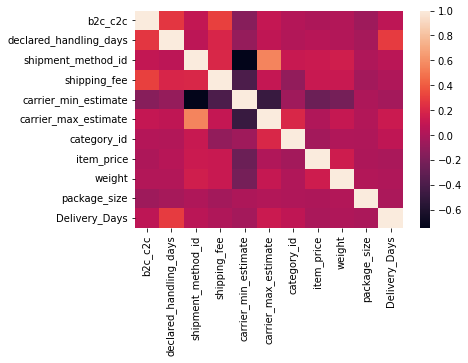

In [68]:
sns.heatmap(df_train_before.corr())

In [4]:
X_trainb = df_train_before.loc[:,df_train_before.columns != 'Delivery_Days']
y_trainb = df_train_before['Delivery_Days']
X_testb = df_test_before.loc[:,df_test_before.columns != 'Delivery_Days']
y_testb = df_test_before['Delivery_Days']

## Calculate Loss Function

In [7]:
Loss_function_Before = []
Loss_function_After = []

In [5]:
def calculate_loss(DD,PDD):
    Early_Shipments = 0
    Late_Shipments= 0
    correct =0
    for i in range(len(DD)):
        days = DD.iloc[i] - PDD.iloc[i]
        if days>0:
            Early_Shipments += days
        elif days<0:
            Late_Shipments -= days
        else:
            correct +=1
    N = len(DD)
    Loss = (0.4*Early_Shipments+0.6*Late_Shipments)/N
    return Loss  

## Multi-Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LRB = LinearRegression()
# fitting the training data
LRB.fit(X_trainb,y_trainb)

LinearRegression()

#### On Test set

In [8]:
y_test_predb =  LRB.predict(X_testb)
y_predb = y_test_predb.round(0)
df_test_pred_B = pd.DataFrame(y_testb)
df_test_pred_B['Pred_LRB'] = y_predb
Loss_Test_LRB = calculate_loss(df_test_pred_B['Delivery_Days'],df_test_pred_B['Pred_LRB'])
Loss_function_Before.append(Loss_Test_LRB)
print(Loss_Test_LRB)

0.7792606666666667


## RandomForest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
clfb = RandomForestClassifier(max_depth=2, random_state=0)
clfb.fit(X_trainb, y_trainb)

RandomForestClassifier(max_depth=2, random_state=0)

#### On Test

In [11]:
RF_y_test_predb =  clfb.predict(X_testb)
df_test_pred_B['Pred_RF'] = RF_y_test_predb.round(0)
Loss_Test_RF = calculate_loss(df_test_pred_B['Delivery_Days'],df_test_pred_B['Pred_RF'])
Loss_function_Before.append(Loss_Test_RF)
print(Loss_Test_RF)

0.6739013333333335


## XG Boost

In [12]:
import xgboost
from xgboost import XGBRegressor

In [13]:
XG_modelb = XGBRegressor()
XG_modelb.fit(X_trainb, y_trainb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

#### On Test

In [14]:
XG_y_test_predb =  XG_modelb.predict(X_testb)
df_test_pred_B['Pred_XG'] = XG_y_test_predb.round(0)
Loss_Test_XG = calculate_loss(df_test_pred_B['Delivery_Days'],df_test_pred_B['Pred_XG'])
Loss_function_Before.append(Loss_Test_XG)
print(Loss_Test_XG)

0.7643013333333334


## Columns after features extraction

['b2c_c2c', 'declared_handling_days', 'shipment_method_id', 'shipping_fee','carrier_min_estimate','carrier_max_estimate', 'category_id', 'item_price','weight', 'Delivery_Days', 'Actual_Handling_Days_For_Seller', 'Declared_Handling_Days_Offset', 'PS__LARGE_PACKAGE', 'PS__LETTER','PS__PACKAGE_THICK_ENVELOPE','Distances_ZIP']

In [15]:
df_train_after = df_train[['b2c_c2c', 'declared_handling_days', 'shipment_method_id', 'shipping_fee','carrier_min_estimate','carrier_max_estimate', 'category_id', 'item_price','weight','Actual_Handling_Days_For_Seller', 'Declared_Handling_Days_Offset', 'PS__LARGE_PACKAGE', 'PS__LETTER','PS__PACKAGE_THICK_ENVELOPE','Distances_ZIP','Delivery_Days']]
df_test_after = df_test[['b2c_c2c', 'declared_handling_days', 'shipment_method_id', 'shipping_fee','carrier_min_estimate','carrier_max_estimate', 'category_id', 'item_price','weight','Actual_Handling_Days_For_Seller', 'Declared_Handling_Days_Offset', 'PS__LARGE_PACKAGE', 'PS__LETTER','PS__PACKAGE_THICK_ENVELOPE','Distances_ZIP','Delivery_Days']]

In [29]:
df_train_after.corr()

,b2c_c2c,declared_handling_days,shipment_method_id,shipping_fee,carrier_min_estimate,carrier_max_estimate,category_id,item_price,weight,Actual_Handling_Days_For_Seller,Declared_Handling_Days_Offset,PS__LARGE_PACKAGE,PS__LETTER,PS__PACKAGE_THICK_ENVELOPE,Distances_ZIP,Delivery_Days
b2c_c2c,1.000000,0.261000,0.086494,0.305757,-0.148949,0.094048,0.023495,-0.000009,0.022900,0.042953,-0.210806,-0.010026,-0.093142,0.085828,-0.037017,0.066316
declared_handling_days,0.261000,1.000000,0.059387,0.190221,-0.099370,0.071896,0.018408,0.036050,0.021082,0.310770,-0.316225,-0.000662,-0.046448,0.042774,-0.022255,0.292046
shipment_method_id,0.086494,0.059387,1.000000,0.197922,-0.748453,0.554564,0.112819,0.124132,0.154287,0.009830,-0.048430,0.033430,-0.031331,0.012629,-0.013881,0.055847
shipping_fee,0.305757,0.190221,0.197922,1.000000,-0.394836,0.094251,-0.108398,0.119846,0.116228,0.019925,-0.167804,0.032238,-0.087989,0.076104,-0.061539,0.005335
carrier_min_estimate,-0.148949,-0.099370,-0.748453,-0.394836,1.000000,-0.484116,-0.054552,-0.269960,-0.229332,-0.016278,0.080154,-0.058751,0.049650,-0.030405,0.057340,-0.034737
carrier_max_estimate,0.094048,0.071896,0.554564,0.094251,-0.484116,1.000000,0.200961,0.015407,0.105676,0.018524,-0.045737,0.045300,-0.018310,-0.001192,-0.021704,0.119763
category_id,0.023495,0.018408,0.112819,-0.108398,-0.054552,0.200961,1.000000,-0.043236,0.013850,0.011546,-0.001076,0.005679,0.007418,-0.008498,-0.008398,0.071861
item_price,-0.000009,0.036050,0.124132,0.119846,-0.269960,0.015407,-0.043236,1.000000,0.136374,0.011245,-0.027357,0.038184,-0.020646,0.012035,-0.010368,-0.013974
weight,0.022900,0.021082,0.154287,0.116228,-0.229332,0.105676,0.013850,0.136374,1.000000,0.004391,-0.016505,0.045495,0.002900,-0.013034,-0.029758,0.004757
Actual_Handling_Days_For_Seller,0.042953,0.310770,0.009830,0.019925,-0.016278,0.018524,0.011546,0.011245,0.004391,1.000000,0.381074,-0.001057,-0.003496,0.003079,0.004172,0.862225


<AxesSubplot:>

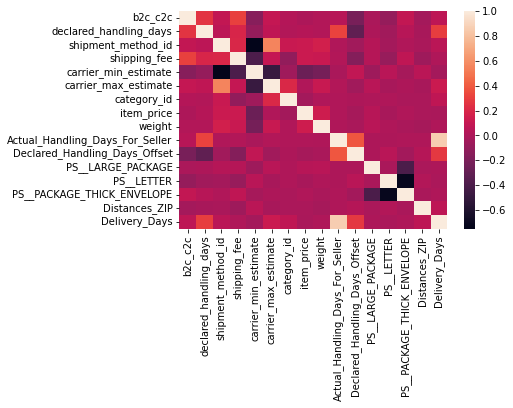

In [30]:
sns.heatmap(df_train_after.corr())

In [16]:
X_traina = df_train_after.loc[:,df_train_after.columns != 'Delivery_Days']
y_traina = df_train_after['Delivery_Days']
X_testa = df_test_after.loc[:,df_test_after.columns != 'Delivery_Days']
y_testa = df_test_after['Delivery_Days']

## Multi-Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
# creating an object of LinearRegression class
LRA = LinearRegression()
# fitting the training data
LRA.fit(X_traina,y_traina)

LinearRegression()

#### On Test Set

In [18]:
y_test_preda =  LRA.predict(X_testa)
df_test_pred_A = pd.DataFrame(y_testa)
df_test_pred_A['Pred_LRA'] =  y_test_preda.round(0)
Loss_Test_LRA = calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_LRA'])
Loss_function_After.append(Loss_Test_LRA)
print(Loss_Test_LRA)

0.48652799999999996


## RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier
clfa = RandomForestClassifier(max_depth=2, random_state=0)
clfa.fit(X_traina, y_traina)

RandomForestClassifier(max_depth=2, random_state=0)

### Calculation of Loss Function for different depths

In [ ]:
## ON TEST
md_value = list(range(2,21,2))
Loss_Test_RFA = []
for i in md_value:
    clfa = RandomForestClassifier(max_depth=i, random_state=0)
    clfa.fit(X_traina, y_traina)
    RF_y_test_preda =  clfa.predict(X_testa)
    df_test_pred_A['Pred_RF'] = RF_y_test_preda.round(0)
    Loss_Test_RFA.append(calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_RF']))

Text(0.5, 1.0, 'Loss Function vs Max_Depth')

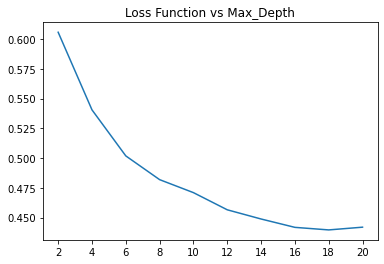

In [68]:
md_value = list(range(2,21,2))
plt.xticks(md_value)
plt.plot(md_value,Loss_Test_RFA)
plt.title("Loss Function vs Max_Depth")

#### On Test Set

In [20]:
RF_y_test_preda =  clfa.predict(X_testa)
df_test_pred_A['Pred_RF'] = RF_y_test_preda.round(0)
Loss_Test_RF_A = calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_RF'])
Loss_function_After.append(Loss_Test_RF_A)
print(Loss_Test_RF_A)

0.605806


## XG Boost

In [21]:
import xgboost
from xgboost import XGBRegressor

In [22]:
XGA_model = XGBRegressor()
XGA_model.fit(X_traina,y_traina)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Calculation of Loss Function for different n_estimators

In [75]:
## ON TEST - 
ne = range(110,201,10)
for i in ne:
    XGA_model = XGBRegressor(n_estimators=i)
    XGA_model.fit(X_traina,y_traina)
    XG_y_test_preda =  XGA_model.predict(X_testa)
    df_test_pred_A['Pred_XG'] = XG_y_test_preda.round(0)
    Loss_Test_XGA_ne.append(calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_XG']))

Text(0.5, 1.0, 'Loss Function vs n_estimators')

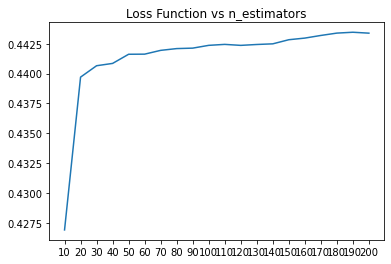

In [76]:
md_value = list(range(10,201,10))
plt.xticks(md_value)
plt.plot(md_value,Loss_Test_XGA_ne)
plt.title("Loss Function vs n_estimators")
plt.figure.subplot_adjust(bottom=0.2)

### Calculation of Loss Function for different depth

In [29]:
mdx = list(range(12,21,2))
for i in mdx:
    XGA_model = XGBRegressor(max_depth=i)
    XGA_model.fit(X_traina,y_traina)
    XG_y_test_preda =  XGA_model.predict(X_testa)
    df_test_pred_A['Pred_XG'] = XG_y_test_preda.round(0)
    Loss_Test_XGA_md.append(calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_XG']))
    print(i)

12
14
16
18
20


Text(0.5, 1.0, 'Loss Function vs Max_Depth')

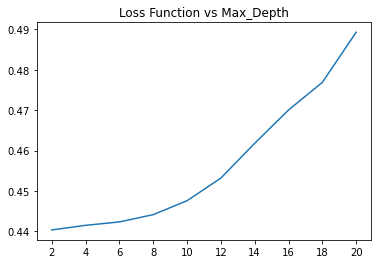

In [32]:
mdx = list(range(2,21,2))
plt.xticks(mdx)
plt.plot(mdx,Loss_Test_XGA_md)
plt.title("Loss Function vs Max_Depth")

### Calculation of Loss Function for different depth and n_estimators

In [53]:
temp = pd.DataFrame(Loss_Test)
temp

,0,1,2
0,0.458609,0.440963,0.426904
1,0.447058,0.439243,0.439705
2,0.442371,0.440737,0.440659
3,0.440812,0.440926,0.440853
4,0.440429,0.441133,0.441620


No handles with labels found to put in legend.


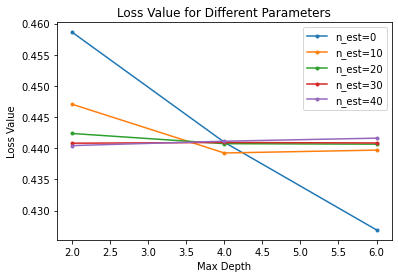

In [78]:
plt.title("Loss Value for Different Parameters")
plt.xlabel("Max Depth")
plt.ylabel("Loss Value")
plt.legend()
for i in range(0,5):
    plt.plot(md,temp.loc[i],'.-')
plt.legend(["n_est="+str(i*10) for i in range(0,5)])    

#### On Test

In [23]:
XG_y_test_preda =  XGA_model.predict(X_testa)
df_test_pred_A['Pred_XG'] = XG_y_test_preda.round(0)
Loss_Test_XGA = calculate_loss(df_test_pred_A['Delivery_Days'],df_test_pred_A['Pred_XG'])
Loss_function_After.append(Loss_Test_XGA)
print(Loss_Test_XGA)

0.4423666666666667


## Plotting Loss values before feature extraction vs Loss values after feature extraction

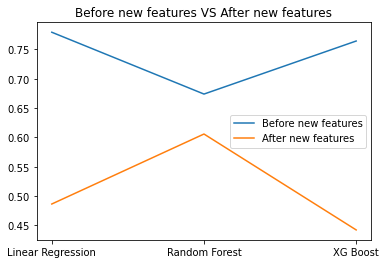

In [24]:
x_labels = ["Linear Regression", "Random Forest", "XG Boost"]
plt.title("Before new features VS After new features")
plt.plot(x_labels, Loss_function_Before)
plt.plot(x_labels, Loss_function_After)
plt.legend(["Before new features", "After new features"]);